In [1]:
import os 

import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(os.path.join(os.path.abspath(''), 'plot_style.mplstyle'))
plots_dir = 'plots/'

from desilike.samples import Profiles, Chain, plotting
from emulator_fit import get_power_likelihood, get_corr_likelihood

tracer = 'ELG'
region = 'SGC'
stat = 'corr'
rp_cut = 2.5

In [2]:
emulator_dir = '/global/cfs/cdirs/desi/users/mpinon/emulators/emulators_shapefit_{}'.format(tracer)
profiles_dir = '/global/cfs/cdirs/desi/users/mpinon/profiles/profiles_shapefit_{}_{{}}{}'.format(tracer, region)
chains_dir = '/global/cfs/cdirs/desi/users/mpinon/chains/chains_shapefit_{}_{{}}{}'.format(tracer, region)
plots_dir = 'plots/'

In [3]:
nmocks = 25
profiles_complete = np.array([Profiles.load(os.path.join(profiles_dir.format('complete_'), '{}_mock{}{}_velocileptors.npy'.format(stat, i, '_xinmax0.35' if stat=='power' else ''))) for i in range(nmocks)])
profiles_complete_rp_cut = np.array([Profiles.load(os.path.join(profiles_dir.format('complete_'), '{}_mock{}{}_velocileptors{}{}{}.npy'.format(stat, i, '_xinmax0.35' if stat=='power' else '', '_fc' if stat=='corr' else '', '_th{:.1f}'.format(rp_cut), '_directedges_max5000' if stat=='power' else ''))) for i in range(nmocks)])

In [4]:
chain_rp_cut = Chain.concatenate([Chain.load(os.path.join(chains_dir.format(''), '{}_velocileptors{}_th{:.1f}_{:d}.npy'.format(stat, '_fc' if stat=='corr' else '', rp_cut, i))).remove_burnin(0.5)[::10] for i in range(8)])

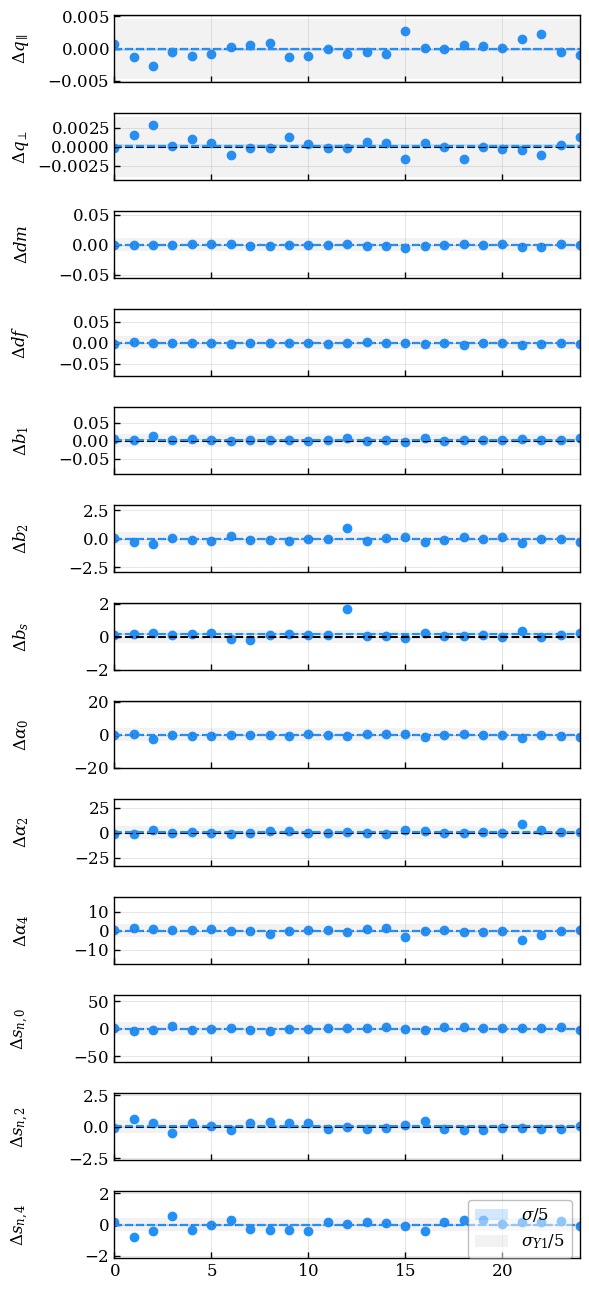

In [5]:
params = ['qpar', 'qper', 'dm', 'df', 'b1', 'b2', 'bs', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2', 'sn4']
nrows = len(params)
figsize = (6, nrows)
fig, lax = plt.subplots(nrows, 1, figsize=figsize, sharex=True)

diff_std_list = []
desi_y1_err_list = []

for iparam, param in enumerate(params):
    bestfit_vals = np.array([profiles_complete[i].choice().bestfit[param] for i in range(nmocks)])
    bestfit_vals_rp_cut = np.array([profiles_complete_rp_cut[i].choice().bestfit[param] for i in range(nmocks)])
    bestfit_diff = bestfit_vals_rp_cut - bestfit_vals
    diff_mean = np.mean(bestfit_diff)
    diff_std = np.std(bestfit_diff) / 5.
    diff_std_list.append(diff_std)
    x = np.arange(len(bestfit_diff))
    ax = lax[iparam]
    ax.axhline(0, ls='--', color='black')
    ax.axhline(diff_mean, ls='--', color='dodgerblue')
    ax.fill_between(x, diff_mean - diff_std, diff_mean + diff_std, facecolor='dodgerblue', alpha=0.2, label=r'$\sigma/5$')
    ax.scatter(x, bestfit_diff)
    ax.set_ylabel(r'$\Delta$'+profiles_complete[0].bestfit[param].param.latex(inline=True))
    # DESI Y1 error
    desi_y1_err = chain_rp_cut.std(param)
    desi_y1_err_list.append(desi_y1_err[0])
    ax.fill_between(x, -desi_y1_err/5., desi_y1_err/5., facecolor='grey', alpha=0.1, label=r'$\sigma_{Y1}/5$')
    ax.set_ylim(-desi_y1_err, desi_y1_err)
    ax.set_xlim(0, np.max(x))
    
    if param in ['qpar', 'qper']:
        ax.set_ylim(-desi_y1_err/4.5, desi_y1_err/4.5)
    
ax.legend()
fig = plt.gcf()
fig.align_ylabels()
plt.savefig(os.path.join(plots_dir, 'bestfit_dispersion_25mocks_{}.png'.format(stat)), dpi=200)
plt.show()

## Use importance sampling to get more robust estimates of the bias and dispersion of best fit parameters over the 25 mocks

In [6]:
chain_rp_cut = Chain.concatenate([Chain.load(os.path.join(chains_dir.format(''), '{}_velocileptors{}_th{:.1f}_{:d}.npy'.format(stat, '_fc' if stat=='corr' else '', rp_cut, i))).remove_burnin(0.5)[::10] for i in range(8)])

In [15]:
chains = [Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), '{}{}_velocileptors_mock{:d}_{:d}.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', imock, ichain))).remove_burnin(0.5)[::10] for ichain in range(8)]) for imock in range(nmocks) if imock not in [6, 17]]
chains_rp_cut =  [Chain.load(os.path.join(chains_dir.format('complete_'), '{}_mock{}_importance{}_velocileptors{}_th{:.1f}{}.npy'.format(stat, imock, '_xinmax0.35' if stat=='power' else '', '_fc' if stat=='corr' else '', rp_cut, '_directedges_max5000' if stat=='power' else ''))) for imock in range(nmocks)  if imock not in [6, 17]]

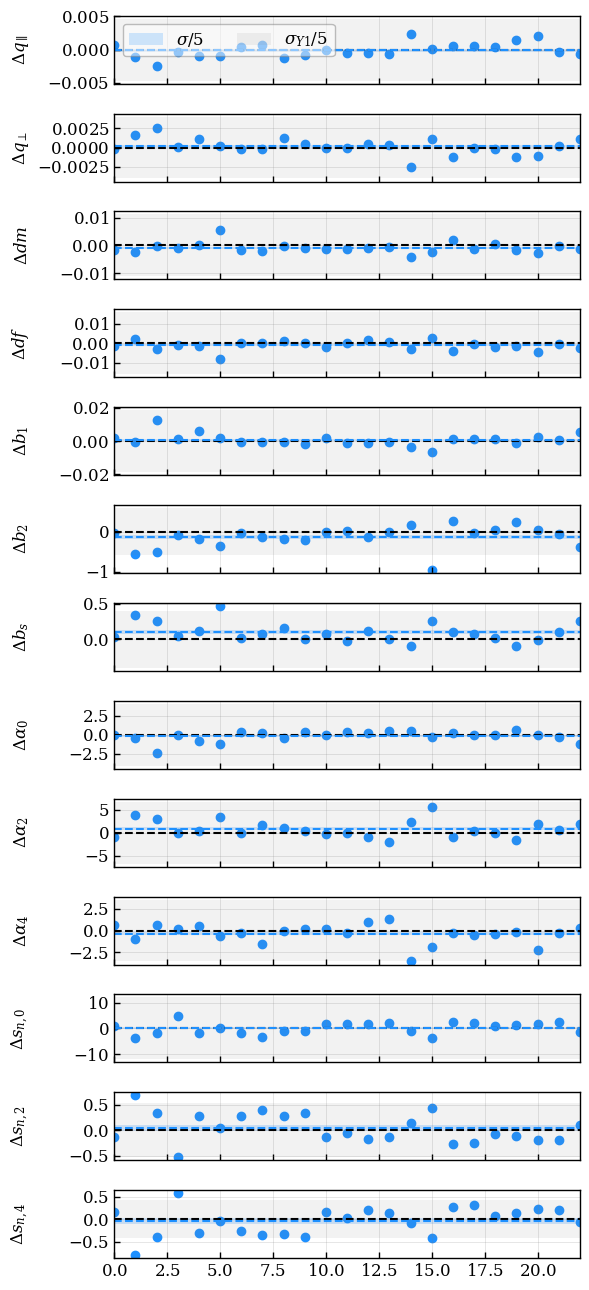

In [16]:
params = ['qpar', 'qper', 'dm', 'df', 'b1', 'b2', 'bs', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2', 'sn4']
nrows = len(params)
figsize = (6, nrows)
fig, lax = plt.subplots(nrows, 1, figsize=figsize, sharex=True)

diff_std_list = []
desi_y1_err_list = []

for iparam, param in enumerate(params):
    bestfit_vals = np.array([chain.mean(param) for chain in chains])
    bestfit_vals_rp_cut = np.array([chain.mean(param) for chain in chains_rp_cut])
    bestfit_diff = bestfit_vals_rp_cut - bestfit_vals
    #print(bestfit_diff)
    diff_mean = np.mean(bestfit_diff)
    diff_std = np.std(bestfit_diff) / 5.
    #print(diff_mean)
    #print(diff_std)
    diff_std_list.append(diff_std)
    x = np.arange(len(bestfit_diff))
    ax = lax[iparam]
    ax.axhline(0, ls='--', color='black')
    ax.axhline(diff_mean, ls='--', color='dodgerblue')
    ax.fill_between(x, diff_mean - diff_std, diff_mean + diff_std, facecolor='dodgerblue', alpha=0.2, label=r'$\sigma/5$')
    ax.scatter(x, bestfit_diff)
    ax.set_ylabel(r'$\Delta$'+profiles_complete[0].bestfit[param].param.latex(inline=True))
    # DESI Y1 error
    desi_y1_err = chain_rp_cut.std(param)
    desi_y1_err_list.append(desi_y1_err[0])
    ax.fill_between(x, -desi_y1_err/5., desi_y1_err/5., facecolor='grey', alpha=0.1, label=r'$\sigma_{Y1}/5$')
    #ax.set_ylim(-desi_y1_err/4., desi_y1_err/4.)
    ax.set_xlim(0, np.max(x))
    
lax[0].legend(ncol=2)
fig = plt.gcf()
fig.align_ylabels()
plt.savefig(os.path.join(plots_dir, 'bestfit_dispersion_25mocks_{}_importance.png'.format(stat)), dpi=200)
plt.show()

In [13]:
chain_list = [[Chain.load(os.path.join(chains_dir.format('complete_'), '{}{}_velocileptors_mock{}_{}.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', imock, i))).remove_burnin(0.5)[::10] for i in range(8)] for imock in range(25)]

0


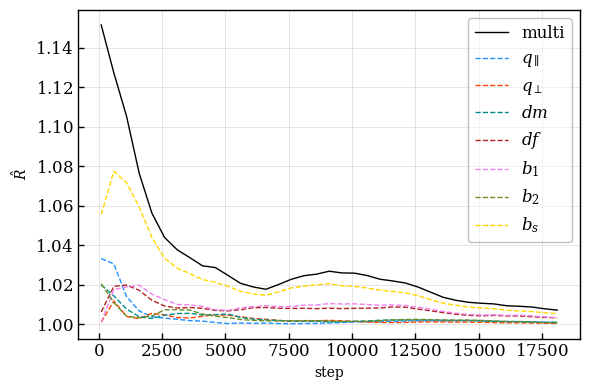

1


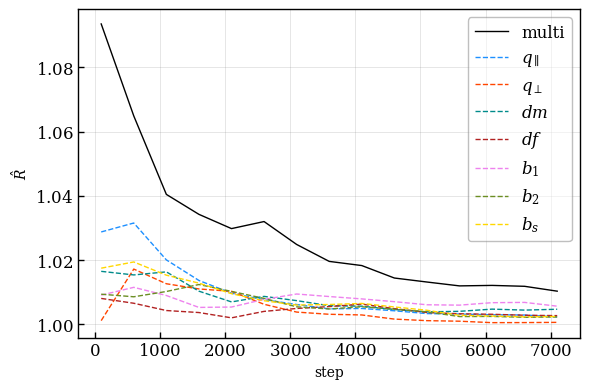

2


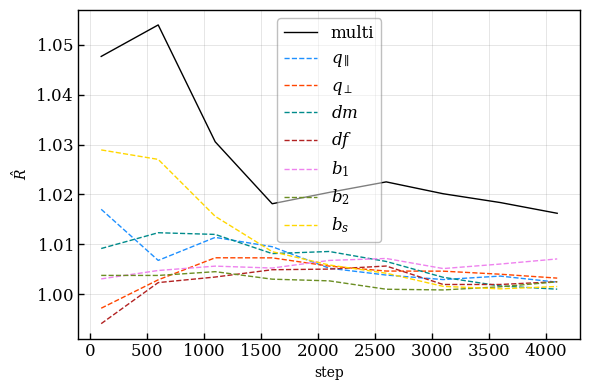

3


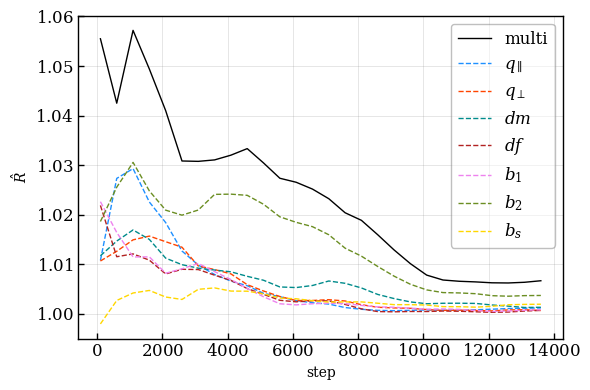

4


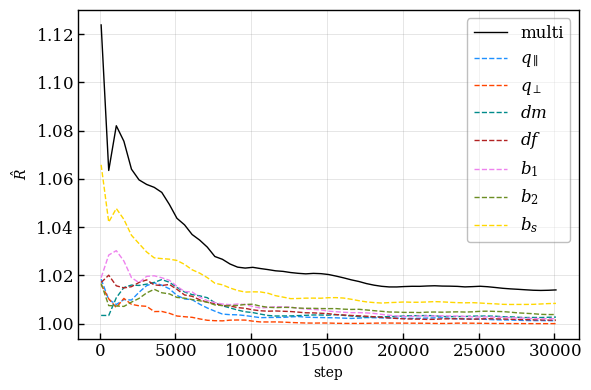

5


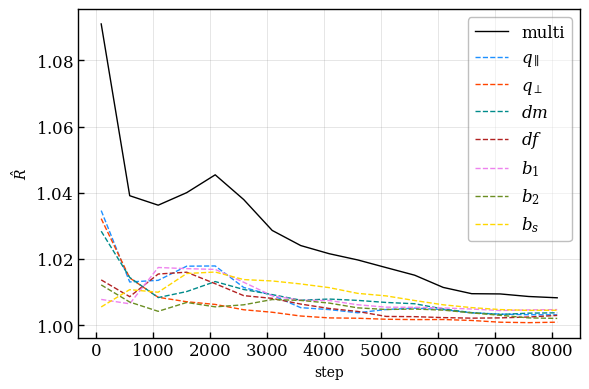

6


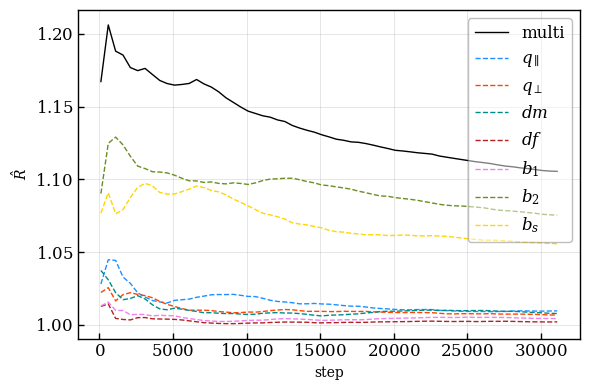

7


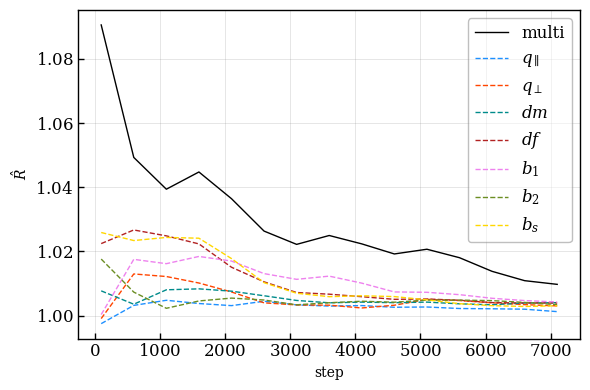

8


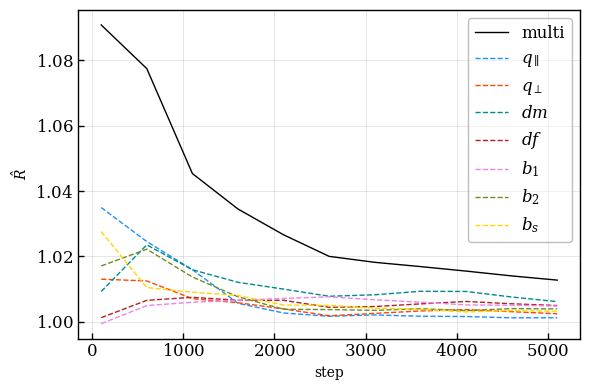

9


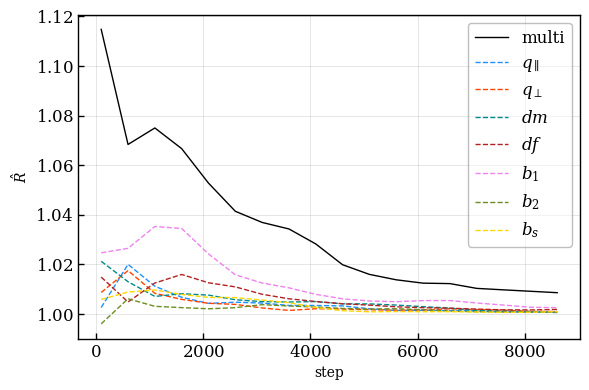

10


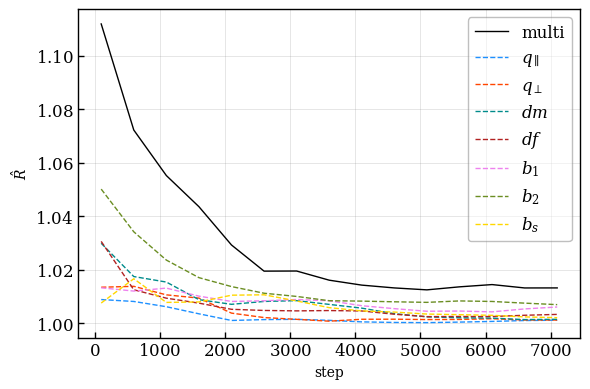

11


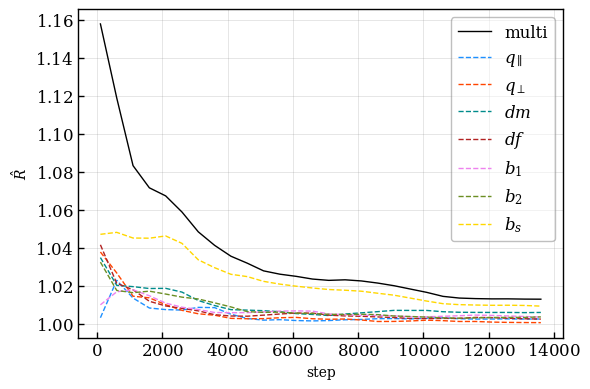

12


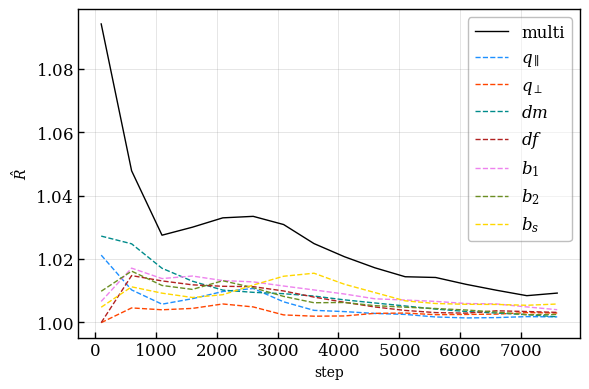

13


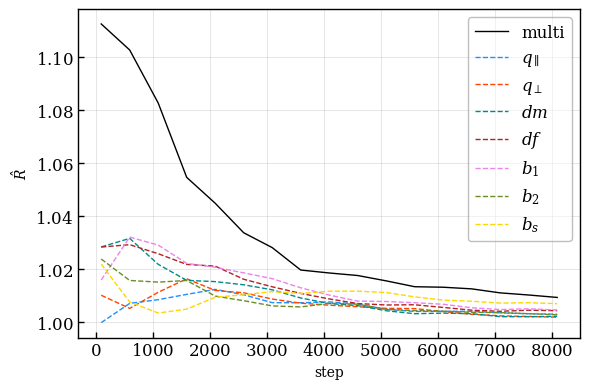

14


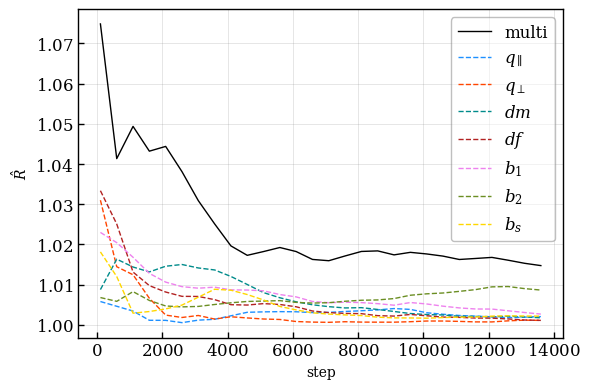

15


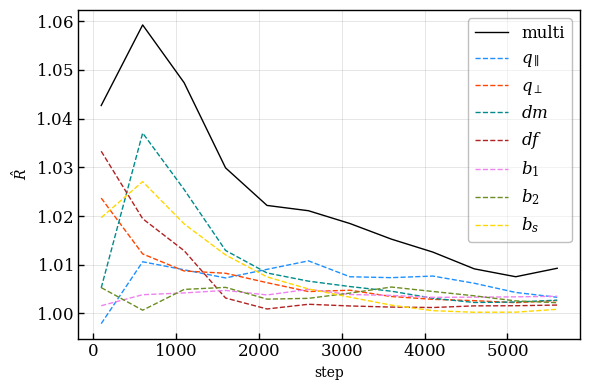

16


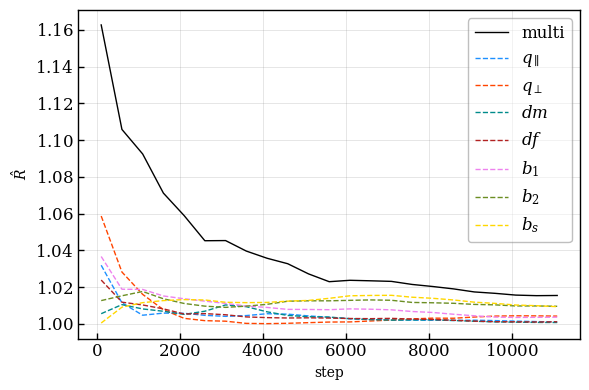

17


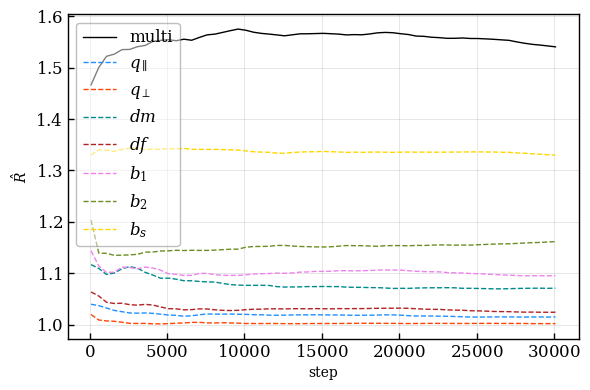

18


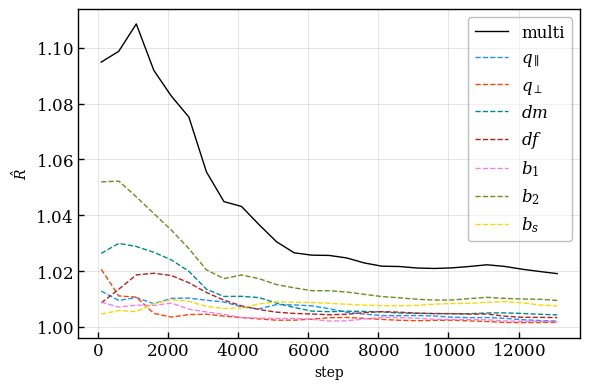

19


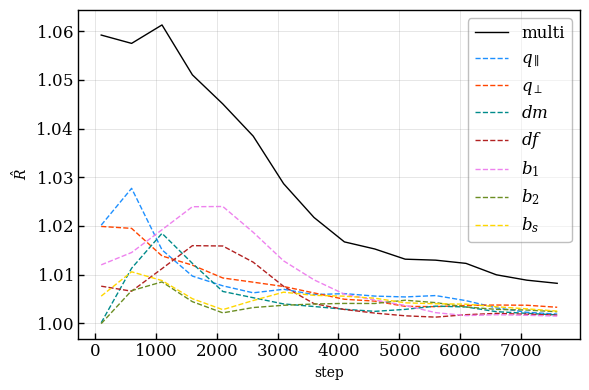

20


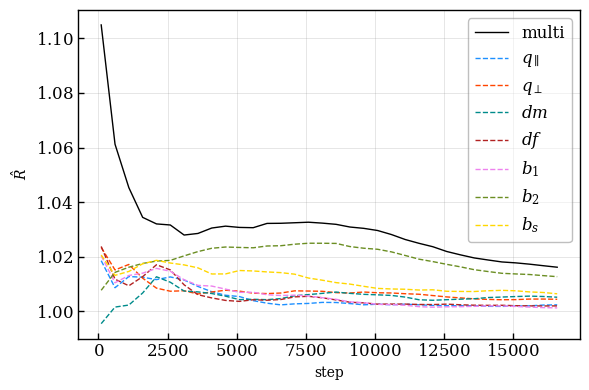

21


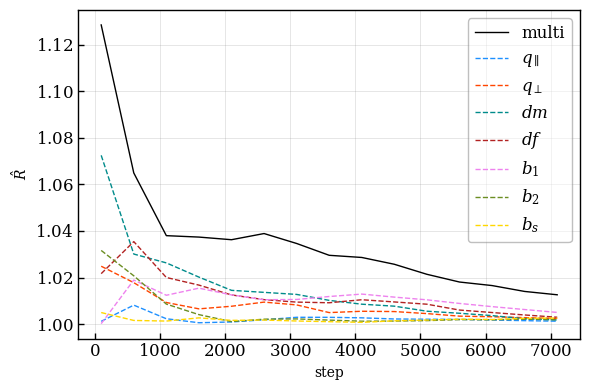

22


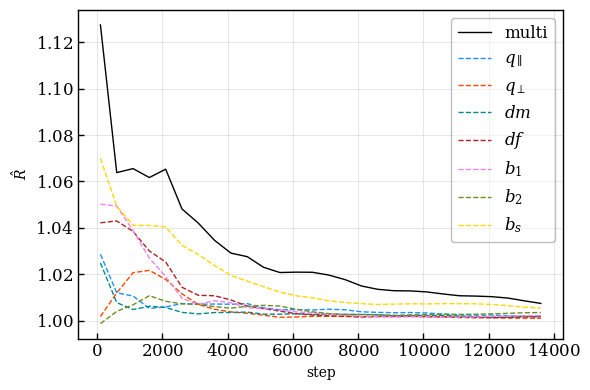

23


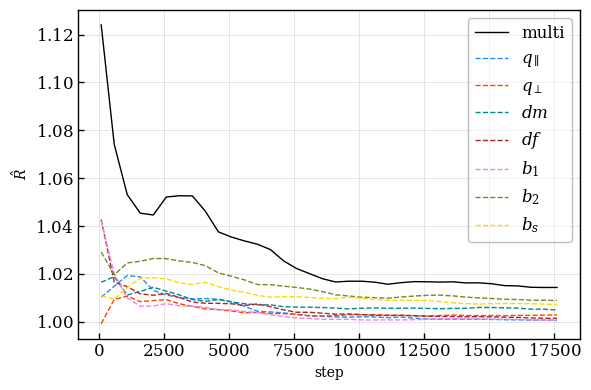

24


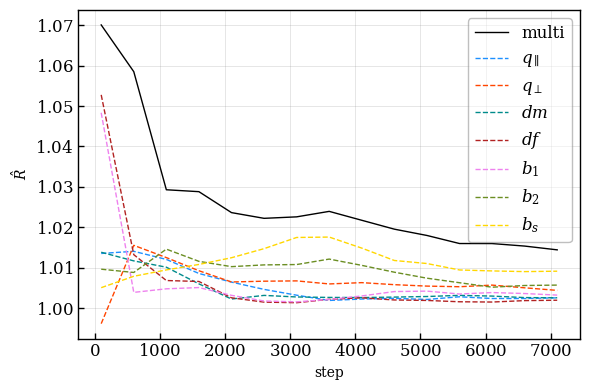

In [14]:
from desilike.samples import plotting

for imock in range(25):
    print(imock)
    plotting.plot_gelman_rubin(chain_list[imock], multivariate=True)
    plt.show()

In [63]:
chain_mock0 = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), '{}{}_velocileptors_mock0_{}.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', i))).remove_burnin(0.5)[::10] for i in range(8)])
#chain_mock0_rpcut = Chain.concatenate([Chain.load(os.path.join(chains_dir.format('complete_'), 'power_xinmax0.35_velocileptors{}{}_mock0_{}.npy'.format('_th{:.1f}'.format(rp_cut) if rp_cut else '', '_directedges_max5000' if rp_cut else '', i))).remove_burnin(0.5)[::10] for i in range(8)])
chain_mock0_importance = Chain.load(os.path.join(chains_dir.format('complete_'), '{}_mock0_importance{}_velocileptors{}_th{:.1f}{}.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', '_fc' if stat=='corr' else '', rp_cut, '_directedges_max5000' if stat=='power' else '')))

In [39]:
from getdist import plots
g = plots.get_single_plotter(width_inch=10, scaling=False, ratio=1)
g.settings.axes_fontsize = 12
g.settings.axes_labelsize = 12

<Figure size 1000x1000 with 0 Axes>

In [100]:
chain_list = [[Chain.load(os.path.join(chains_dir.format('complete_'), '{}{}_velocileptors_mock{}_{}.npy'.format(stat, '_xinmax0.35' if stat=='power' else '', imock, i))).remove_burnin(0.)[:100:10] for i in range(8)] for imock in range(25)]

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/global/cfs/cdirs/desi/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


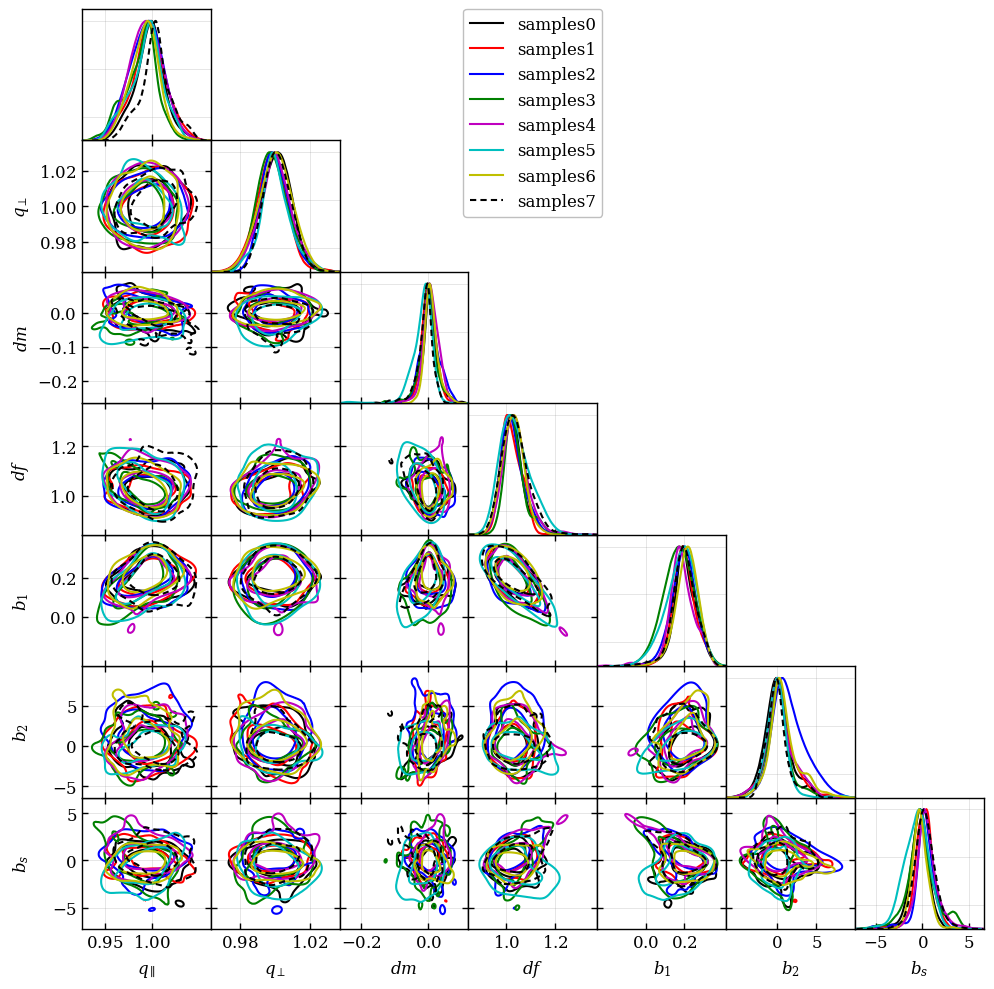

In [101]:
plotting.plot_triangle(#[chain_mock0, chain_mock0_importance][:1],
                       chain_list[17],
                       #labels=[r'MCMC w.o. $r_{p}$-cut', 'Importance'],
                       params=['qpar', 'qper', 'df', 'dm', 'b1', 'b2', 'bs'],
                       g=g, lws=1.5, contour_lws=1.5, filled=False,
                       show=False)
fig = plt.gcf()
fig.align_ylabels()
plt.show()

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/global/cfs/cdirs/desi/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


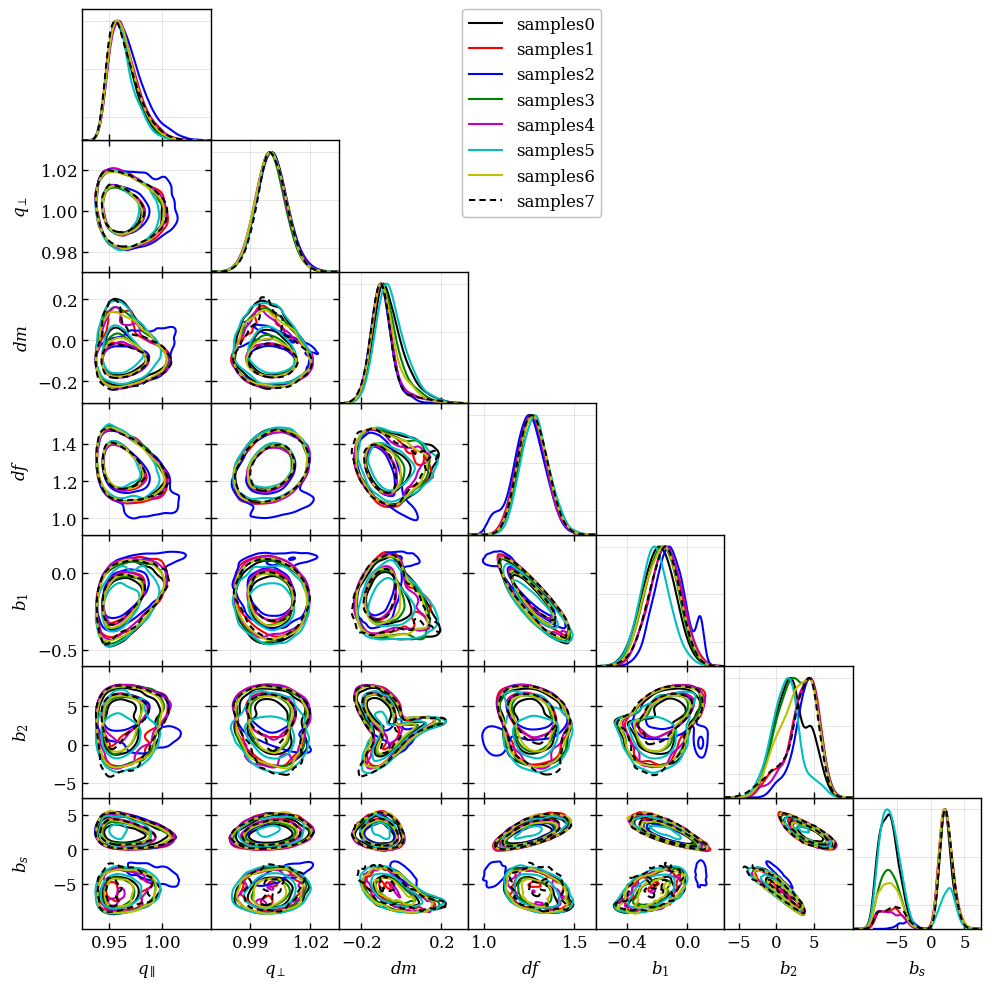

In [99]:
plotting.plot_triangle(#[chain_mock0, chain_mock0_importance][:1],
                       chain_list[17],
                       #labels=[r'MCMC w.o. $r_{p}$-cut', 'Importance'],
                       params=['qpar', 'qper', 'df', 'dm', 'b1', 'b2', 'bs'],
                       g=g, lws=1.5, contour_lws=1.5, filled=False,
                       show=False)
fig = plt.gcf()
fig.align_ylabels()
plt.show()

Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


/global/cfs/cdirs/desi/users/adematti/perlmutter/cosmodesiconda/20221205-1.0.0/conda/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


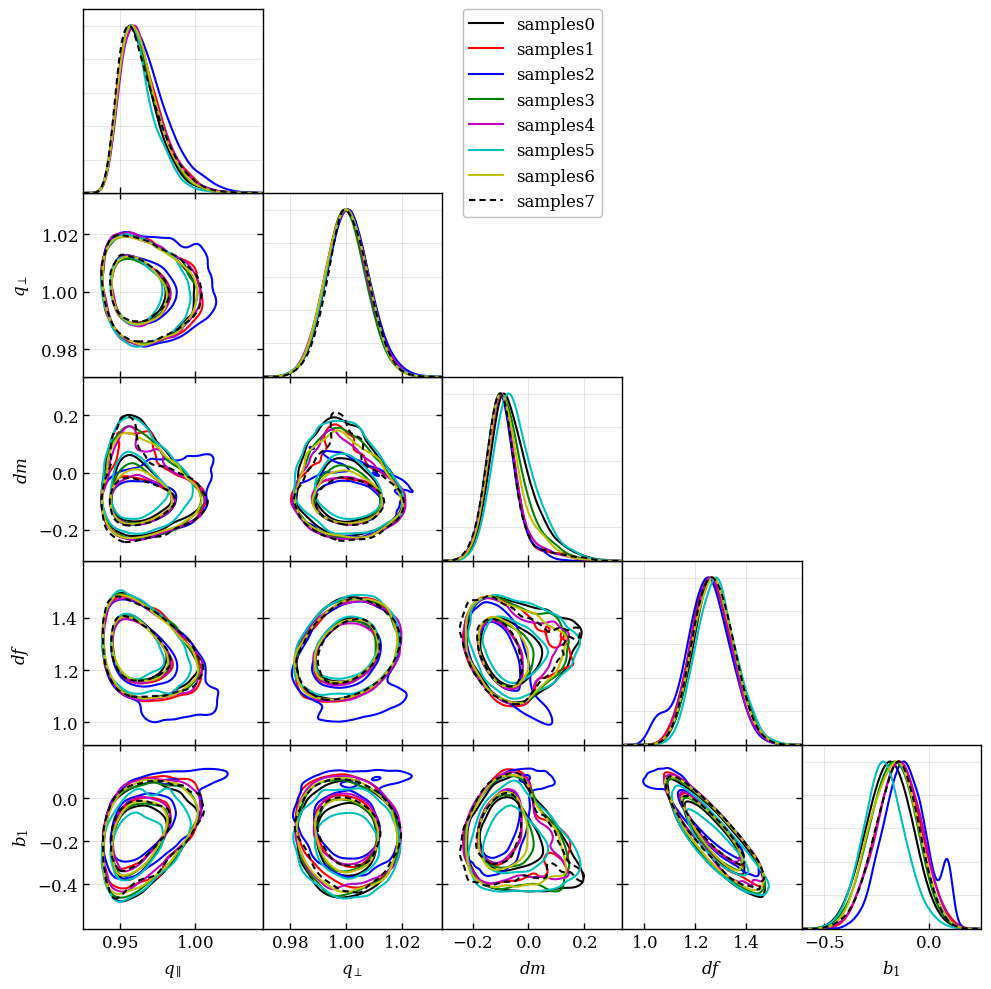

In [84]:
plotting.plot_triangle(#[chain_mock0, chain_mock0_importance][:1],
                       chain_list[17],
                       #labels=[r'MCMC w.o. $r_{p}$-cut', 'Importance'],
                       params=['qpar', 'qper', 'df', 'dm', 'b1'],
                       g=g, lws=1.5, contour_lws=1.5, filled=False,
                       show=False)
fig = plt.gcf()
fig.align_ylabels()
plt.show()